In [1]:
import os, sys
import re
import time
from collections import Counter

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

# import torch
# import torchvision
# import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import cv2
from tqdm import tqdm
import sklearn.utils


In [2]:
options = {
    'output_snippet_dir': "/projectnb/saenkog/awong1/dataset/kitti/processed2",
    "input_kitti_img_path": "/projectnb/saenkog/awong1/dataset/kitti/training/image_02",
    "input_kitti_label_path": "/projectnb/saenkog/awong1/dataset/kitti/training/label_02",
    'validation_video_id': '0014',
    'test_video_id': '0012'
}

In [3]:
# Load label txt for video
HEADER = [
    "frame",
    "track_id",
    "type",
    "truncated",
    "occluded",
    "alpha",
    "bbox_l",
    "bbox_t",
    "bbox_r",
    "bbox_b",
    "dim_h",
    "dim_w",
    "dim_l",
    "loc_x",
    "loc_y",
    "loc_z",
    "rot_y",
    "score"
]

lab_dir = options["input_kitti_label_path"]
label = pd.read_csv(lab_dir + "/0000.txt",  sep=" ", names=HEADER)
label

,frame,track_id,type,truncated,occluded,alpha,bbox_l,bbox_t,bbox_r,bbox_b,dim_h,dim_w,dim_l,loc_x,loc_y,loc_z,rot_y,score
0,0,-1,DontCare,-1,-1,-10.000000,219.310000,188.490000,245.500000,218.560000,-1000.000000,-1000.000000,-1000.000000,-10.000000,-1.000000,-1.000000,-1.000000,NaN
1,0,-1,DontCare,-1,-1,-10.000000,47.560000,195.280000,115.480000,221.480000,-1000.000000,-1000.000000,-1000.000000,-10.000000,-1.000000,-1.000000,-1.000000,NaN
2,0,0,Van,0,0,-1.793451,296.744956,161.752147,455.226042,292.372804,2.000000,1.823255,4.433886,-4.552284,1.858523,13.410495,-2.115488,NaN
3,0,1,Cyclist,0,0,-1.936993,737.619499,161.531951,931.112229,374.000000,1.739063,0.824591,1.785241,1.640400,1.675660,5.776261,-1.675458,NaN
4,0,2,Pedestrian,0,0,-2.523309,1106.137292,166.576807,1204.470628,323.876144,1.714062,0.767881,0.972283,6.301919,1.652419,8.455685,-1.900245,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,153,10,Car,0,2,-1.818856,680.294919,177.511028,842.313244,284.070033,1.524000,1.728591,3.894227,2.353367,1.622590,12.436503,-1.637280,NaN
1085,153,11,Car,0,2,1.864481,245.920800,194.456182,394.817829,286.444967,1.444000,1.595116,3.791789,-5.458963,1.908188,13.979427,1.497916,NaN
1086,153,12,Pedestrian,1,0,0.826456,1185.199080,151.165841,1241.000000,348.552707,1.688000,0.800000,0.884000,5.739732,1.500532,6.279632,1.543272,NaN
1087,153,13,Car,0,0,1.773993,344.361560,188.772369,430.531955,248.482384,1.422414,1.512803,3.707634,-6.033258,1.888008,19.788795,1.481180,NaN


In [4]:
# Traverse training set and label

train_dir = options["input_kitti_img_path"]
train_label_dir = options["input_kitti_label_path"]

# image_class_info = {}
image_class_info = pd.DataFrame(columns=["video_id", "frame_id", "class", "image_path"])

for dirname in sorted(os.listdir(train_dir)):
    tot_frame = 0
    # Get corresponding train labels
    label = pd.read_csv(train_label_dir + "/" + dirname + ".txt", sep=" ", names=HEADER)
    # Traverse image dir
    for filename in sorted(os.listdir(train_dir + "/" + dirname)):
        tot_frame += 1
        image_path = train_dir + "/" + dirname + "/" + filename

        # parse frame id from filename
        cur_frame_id = int(re.sub(r"\.png", "", filename))
        
        # select label rows with corresponding frame id
        cur_label = label[label["frame"] == cur_frame_id]
        types = list(cur_label["type"])
        
        pedestrian_labels = cur_label[cur_label["type"] == "Pedestrian"]
        bbox_l = ",".join([str(v) for v in pedestrian_labels["bbox_l"].tolist()])
        bbox_t = ",".join([str(v) for v in pedestrian_labels["bbox_t"].tolist()])
        bbox_r = ",".join([str(v) for v in pedestrian_labels["bbox_r"].tolist()])
        bbox_b = ",".join([str(v) for v in pedestrian_labels["bbox_b"].tolist()])
        
        new_row = {"video_id": dirname,
                   "frame_id": cur_frame_id,
                   "class": 0,
                   "image_path": image_path,
                   "bbox_l": bbox_l,
                   "bbox_t": bbox_t,
                   "bbox_r": bbox_r,
                   "bbox_b": bbox_b}
        
        # detect class-0 / class-1(w/t pedestrian)
        if "Pedestrian" in types:
            new_row["class"] = 1
        
        image_class_info = image_class_info.append(new_row, ignore_index=True)
        
        # print("  %s => types: [%s]" % (filename, ", ".join(types)))
    print("Total frames for video %s: %i" % (dirname, tot_frame))
    

Total frames for video 0000: 154
Total frames for video 0001: 447
Total frames for video 0002: 233
Total frames for video 0003: 144
Total frames for video 0004: 314
Total frames for video 0005: 297
Total frames for video 0006: 270
Total frames for video 0007: 800
Total frames for video 0008: 390
Total frames for video 0009: 803
Total frames for video 0010: 294
Total frames for video 0011: 373
Total frames for video 0012: 78
Total frames for video 0013: 340
Total frames for video 0014: 106
Total frames for video 0015: 376
Total frames for video 0016: 209
Total frames for video 0017: 145
Total frames for video 0018: 339
Total frames for video 0019: 1059
Total frames for video 0020: 837


# Video Class Ratio Analysis

In [5]:
print("video id containing pedestrian")
print(np.unique(image_class_info[image_class_info['class'] == 1]['video_id']))

print("video id containing no pedestrian")
print(np.unique(image_class_info[image_class_info['class'] == 0]['video_id']))

def get_video_class_ratio(image_class_info, video_id):
    vid_image_class_info = image_class_info[image_class_info['video_id'] == video_id]
    counts = vid_image_class_info.groupby(["class"]).size()
#     print(counts)
    if len(counts) < 2:
        ratio = 0
    else:
        ratio = counts[1]/counts[0]
    return counts, ratio

vid_ids = np.unique(image_class_info['video_id'])
for vid_id in vid_ids:
    counts, ratio = get_video_class_ratio(image_class_info, vid_id)
    frames = len(image_class_info[image_class_info['video_id'] == vid_id])
    print("vid id = {} | ratio = {}, counts = {}, frames = {}\n".format(vid_id, ratio, counts, frames))

video id containing pedestrian
['0000' '0001' '0002' '0004' '0007' '0009' '0010' '0011' '0012' '0013'
 '0014' '0015' '0016' '0017' '0019']
video id containing no pedestrian
['0000' '0001' '0002' '0003' '0004' '0005' '0006' '0007' '0008' '0009'
 '0010' '0011' '0012' '0013' '0014' '0015' '0018' '0019' '0020']
vid id = 0000 | ratio = 0.16666666666666666, counts = class
0    132
1     22
dtype: int64, frames = 154

vid id = 0001 | ratio = 0.21138211382113822, counts = class
0    369
1     78
dtype: int64, frames = 447

vid id = 0002 | ratio = 3.3962264150943398, counts = class
0     53
1    180
dtype: int64, frames = 233

vid id = 0003 | ratio = 0, counts = class
0    144
dtype: int64, frames = 144

vid id = 0004 | ratio = 0.15018315018315018, counts = class
0    273
1     41
dtype: int64, frames = 314

vid id = 0005 | ratio = 0, counts = class
0    297
dtype: int64, frames = 297

vid id = 0006 | ratio = 0, counts = class
0    270
dtype: int64, frames = 270

vid id = 0007 | ratio = 0.09140

In [6]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
#     assert bb1['x1'] < bb1['x2']
#     assert bb1['y1'] < bb1['y2']
#     assert bb2['x1'] < bb2['x2']
#     assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    #iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    #assert iou >= 0.0
    #assert iou <= 1.0
    if float(bb2_area) == 0.0:
        return 0.0
    return float(intersection_area)/float(bb2_area)

a1 = {"x1": 400, "x2": 624, "y1": 0, "y2": 224}
a2 = {"x1": 230, "x2": 261, "y1": 169, "y2": 255} #514 573 88 195 #230 261 169 255
get_iou(a1, a2)

# from bbox import BBox2D, XYXY
# from bbox.metrics import jaccard_index_2d

# a1 = BBox2D([400, 0, 624, 224], mode=XYXY)
# a2 = BBox2D([230, 169, 230, 255], mode=XYXY)
# jaccard_index_2d(a1, a2)

0.0

# Split into train-val-test set

In [7]:
def crop_img(img_class_info, disp_img = True):
    cropped_img_info = pd.DataFrame(columns=["img", "has_pedestrian"])
    
    # for i, (index, row) in tqdm(enumerate(balanced_image_class_info[balanced_image_class_info["class"] == 1].iterrows())):
    for i, (index, row) in tqdm(enumerate(img_class_info.iterrows())):
        img = cv2.imread(row["image_path"], cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_resize = cv2.resize(img, (int(img.shape[1]*224/img.shape[0]), 224))
        if disp_img:
            plt.imshow(img_resize)    
        # mask = np.zeros((img_resize.shape[0], img_resize.shape[1]))

        # Cropping and detecting bounding box IoU
        crop_idx = np.random.randint(0, img_resize.shape[1]-224)
        img_crop = img_resize[:, crop_idx:crop_idx+224]
        has_full_pedestrian = False

        # Using bounding box info
        if row["bbox_l"] != "":
            ax = plt.gca()
            for tup in zip(row["bbox_l"].split(","), row["bbox_t"].split(","), row["bbox_r"].split(","), row["bbox_b"].split(",")):
                bbox_l = int(float(tup[0])*740/1240)
                bbox_t = int(float(tup[1])*224/375)
                bbox_r = int(float(tup[2])*740/1240)
                bbox_b = int(float(tup[3])*224/375)

                # mask[bbox_t: bbox_b, bbox_l:bbox_r] = 1.0

                # Calculate IoU?
                crop_box = {"x1": crop_idx, "x2": crop_idx+224, "y1": 0, "y2": 224}
                obj_box = {"x1": bbox_l, "x2": bbox_r, "y1": bbox_t, "y2": bbox_b}
                coverage = get_iou(crop_box, obj_box)
                if coverage > 0.79:
                    has_full_pedestrian = True
#                 rect = patches.Rectangle((bbox_l, bbox_t), (bbox_r - bbox_l), (bbox_b - bbox_t), linewidth=2, edgecolor='lawngreen', facecolor='none', label="%.2f"%coverage)
#                 ax.add_patch(rect)
        if disp_img:
            plt.show()    
            plt.imshow(img_crop)
            print(has_full_pedestrian)
            plt.show()

        new_row = {"img": img_crop,
           "has_pedestrian": has_full_pedestrian}
        cropped_img_info = cropped_img_info.append(new_row, ignore_index=True)


#         if i > 10: break
    cropped_img_info = sklearn.utils.shuffle(cropped_img_info)
    return cropped_img_info


8008it [02:05, 63.85it/s]
106it [00:01, 69.61it/s]
78it [00:01, 68.43it/s]


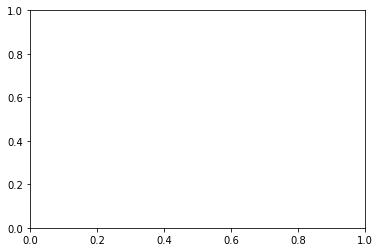

In [8]:
train_video_id = np.logical_or(image_class_info['video_id'] != options['validation_video_id'], image_class_info['video_id'] != options['test_video_id'])

train_img_class_info = image_class_info[train_video_id]
train_processed_info = crop_img(train_img_class_info, disp_img=False)

val_img_class_info = image_class_info[train_img_class_info['video_id'] == options['validation_video_id']]
val_processed_info = crop_img(val_img_class_info, disp_img=False)

test_img_class_info = image_class_info[train_img_class_info['video_id'] == options['test_video_id']]
test_processed_info = crop_img(test_img_class_info, disp_img=False)

In [9]:
print(len(train_processed_info))
print(len(val_processed_info))
print(len(test_processed_info))

8008
106
78


min_len=78, rand_idx=72
train_processed_info
False


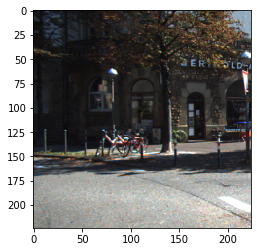

val_processed_info
False


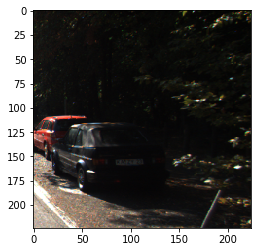

test_processed_info
False


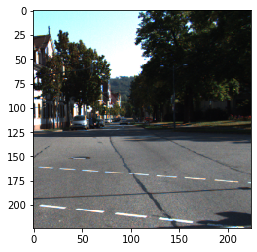

In [10]:
min_len = min(len(val_processed_info['img']), len(test_processed_info['img']))
rand_idx = np.random.randint(min_len)
print("min_len={}, rand_idx={}".format(min_len, rand_idx))

print("train_processed_info")
plt.imshow(train_processed_info['img'][rand_idx])
print(train_processed_info['has_pedestrian'][rand_idx])
plt.show()

print("val_processed_info")
plt.imshow(val_processed_info['img'][rand_idx])
print(val_processed_info['has_pedestrian'][rand_idx])
plt.show()

print("test_processed_info")
plt.imshow(test_processed_info['img'][rand_idx])
print(test_processed_info['has_pedestrian'][rand_idx])
plt.show()

# Balance Class Ratio in train-val-test sets

In [11]:
def find_class_ratio(processed_info, info_type):
    has_pedestrian_count = len(processed_info[processed_info['has_pedestrian'] == True])
    no_pedestrian_count = len(processed_info[processed_info['has_pedestrian'] == False])
    return {'has_pedestrian_count': has_pedestrian_count, 'no_pedestrian_count': no_pedestrian_count}

In [12]:
print("train_processed_info:", find_class_ratio(train_processed_info, "train_processed_info"))
print("val_processed_info:", find_class_ratio(val_processed_info, "val_processed_info"))
print("test_processed_info:", find_class_ratio(test_processed_info, "test_processed_info"))

train_processed_info: {'has_pedestrian_count': 1526, 'no_pedestrian_count': 6482}
val_processed_info: {'has_pedestrian_count': 16, 'no_pedestrian_count': 90}
test_processed_info: {'has_pedestrian_count': 23, 'no_pedestrian_count': 55}


In [13]:
def gen_balance_class_ratio(processed_info, info_type):
    class_ratio = find_class_ratio(processed_info, info_type)
    print("{} | has_pedestrian_count={}, no_pedestrian_count={}".format(info_type, class_ratio['has_pedestrian_count'], class_ratio['no_pedestrian_count']))
    min_len = min((class_ratio['has_pedestrian_count']), (class_ratio['no_pedestrian_count']))
    
    has_pedestrian_df = processed_info[processed_info['has_pedestrian'] == True][:min_len]
    no_pedestrian_df = processed_info[processed_info['has_pedestrian'] == False][:min_len]
        
    balanced_df = pd.DataFrame(columns=["img", "has_pedestrian"])
    balanced_df = pd.concat([balanced_df, has_pedestrian_df, no_pedestrian_df])
    return balanced_df

In [14]:
train_balanced_info = gen_balance_class_ratio(train_processed_info, "train_processed_info")
val_balanced_info = gen_balance_class_ratio(val_processed_info, "val_processed_info")
test_balanced_info = gen_balance_class_ratio(test_processed_info, "test_processed_info")

train_processed_info | has_pedestrian_count=1526, no_pedestrian_count=6482
val_processed_info | has_pedestrian_count=16, no_pedestrian_count=90
test_processed_info | has_pedestrian_count=23, no_pedestrian_count=55


# Loop and Write as image

In [15]:
def write_to_out(balanced_info_df, output_snippet_dir, data_type="train"):
    has_p_count = 0
    no_p_count = 0
    out_data_type_dir = output_snippet_dir + "/" + data_type
    
    for i, (index, row) in tqdm(enumerate(balanced_info_df.iterrows())):
        if row['has_pedestrian'] == True:
            class_name = 'has_pedestrian'
            has_p_count += 1
        else:
            class_name = 'no_pedestrian'
            no_p_count += 1

        out_path = out_data_type_dir + "/" + class_name + "/" + str(i) + ".png"
#         print(out_path)
        cv2.imwrite(out_path, row['img'])
    print("Wrote {} has_pedestrian and {} no_pedestrian images to {}".format(has_p_count, no_p_count, out_data_type_dir))


In [16]:
write_to_out(train_balanced_info, options['output_snippet_dir'], "training")
write_to_out(val_balanced_info, options['output_snippet_dir'], "validation")
write_to_out(test_balanced_info, options['output_snippet_dir'], "testing")

3052it [00:13, 223.60it/s]
32it [00:00, 234.89it/s]
0it [00:00, ?it/s]

Wrote 1526 has_pedestrian and 1526 no_pedestrian images to /projectnb/saenkog/awong1/dataset/kitti/processed2/training
Wrote 16 has_pedestrian and 16 no_pedestrian images to /projectnb/saenkog/awong1/dataset/kitti/processed2/validation


46it [00:00, 203.95it/s]

Wrote 23 has_pedestrian and 23 no_pedestrian images to /projectnb/saenkog/awong1/dataset/kitti/processed2/testing
